In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as sum_col, avg, when, to_date, year, month, dayofweek, lit, lag, count, row_number
from pyspark.sql.functions import min as spark_min, max as spark_max, avg as spark_avg
from pyspark.sql.window import Window
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder \
    .appName("COVID19_Brasil_Analysis") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "5g") \
    .getOrCreate()


display("Spark Session iniciada com sucesso!")

'Spark Session iniciada com sucesso!'

In [2]:
caminho_do_parquet_tratado = "datasets_base\df_covid_tratado.parquet"
df_base_para_analise = spark.read.parquet(caminho_do_parquet_tratado)
df_base_para_analise.cache()
print("DataFrame base para análise carregado com sucesso!")
df_base_para_analise.printSchema()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\lrodr\AppData\Local\Temp\ipykernel_22716\3272377065.py:1: SyntaxWarning: invalid escape sequence '\d'
  caminho_do_parquet_tratado = "datasets_base\df_covid_tratado.parquet"


DataFrame base para análise carregado com sucesso!
root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: date (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: double (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)
 |-- ano_data: integer (nullable = true)
 |-- mes_data: integer (nullable = true)
 |-- dia_semana_num: integer (nullable = true)
 |-- dia_semana_nome: string (nullable = true)



## Verificar a média de casos e obitos diarios

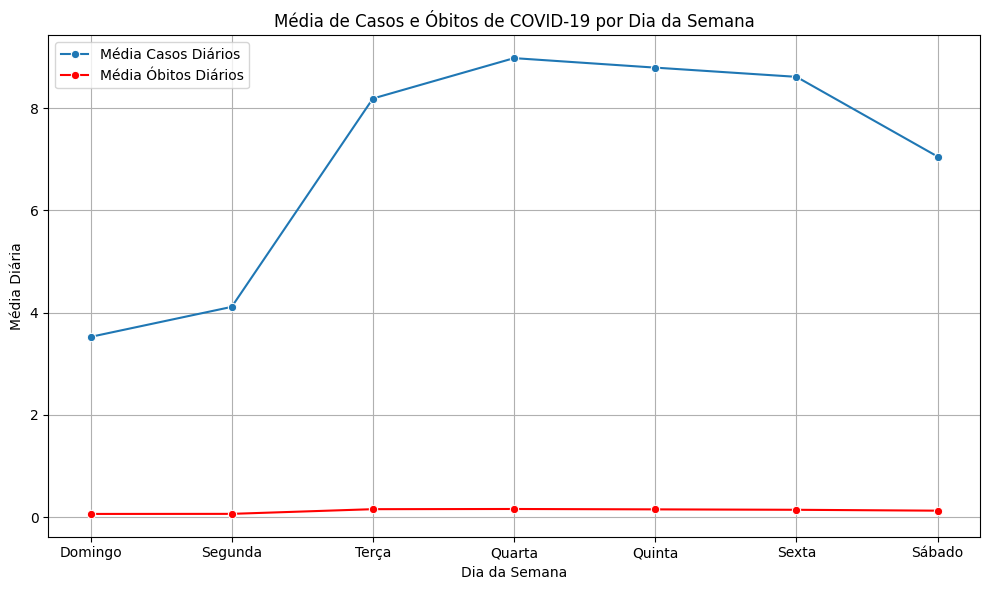

In [3]:


df_dia_semana_agg = df_base_para_analise.groupBy("dia_semana_nome", "dia_semana_num").agg(
    avg(col("casosNovos")).alias("media_casos_diarios"),
    avg(col("obitosNovos")).alias("media_obitos_diarios")
).orderBy("dia_semana_num") # Agora 'dia_semana_num' estará disponível para ordenação

df_dia_semana_pandas = df_dia_semana_agg.toPandas()

# O restante do seu código para plotagem...
plt.figure(figsize=(10, 6))
sns.lineplot(x='dia_semana_nome', y='media_casos_diarios', data=df_dia_semana_pandas, marker='o', label='Média Casos Diários')
sns.lineplot(x='dia_semana_nome', y='media_obitos_diarios', data=df_dia_semana_pandas, marker='o', label='Média Óbitos Diários', color='red')
plt.title('Média de Casos e Óbitos de COVID-19 por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Média Diária')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('media_casos_obitos_dia_semana.png', dpi=300)
plt.show()

- *Foi observado queda de casos nos finais de semana, isso pode indicar atraso nos registros nesses dias em espécifico*

## Segunda verificação de duplicadas afim de validar as quantidades de casos

In [4]:
print("Verificando registros duplicados...")

# Define as colunas que identificam uma linha única (chave primária)
identificadores_unicos = ["data", "municipio", "estado"]

# Conta o número de linhas distintas baseadas nos identificadores
num_linhas_distintas = df_base_para_analise.select(identificadores_unicos).distinct().count()

# Conta o número total de linhas
num_linhas_total = df_base_para_analise.count()

print(f"Número total de linhas: {num_linhas_total}")
print(f"Número de linhas distintas por (data, município, estado): {num_linhas_distintas}")

if num_linhas_total > num_linhas_distintas:
    print("Foram encontrados registros duplicados para a combinação (data, município, estado).")
    # Para ver os duplicados, você pode fazer:
    df_base_para_analise.groupBy(identificadores_unicos).count() \
                        .filter(col("count") > 1).orderBy(col("count").desc()).show(5)
    # Se houver duplicados, remova-os (a não ser que haja um motivo para mantê-los)
    # df_base_para_analise = df_base_para_analise.dropDuplicates(identificadores_unicos)
    # print(f"Número de linhas após remover duplicados: {df_base_para_analise.count()}")
else:
    print("Nenhum registro duplicado encontrado para a combinação (data, município, estado).")


Verificando registros duplicados...
Número total de linhas: 4066100
Número de linhas distintas por (data, município, estado): 4066100
Nenhum registro duplicado encontrado para a combinação (data, município, estado).


- *Sem duplicadas*

## Verificar inconsistencia nos casos acumulados

In [5]:
print("\nVerificando a consistência dos valores acumulados (não decrescentes)...")

# Define a janela de partição para analisar por município e estado, ordenada por data
window_spec = Window.partitionBy("municipio", "estado").orderBy("data")

# Cria colunas para o valor acumulado do dia anterior
df_inconsistencia = df_base_para_analise.withColumn(
    "casosAcumulado_anterior", lag(col("casosAcumulado"), 1).over(window_spec)
).withColumn(
    "obitosAcumulado_anterior", lag(col("obitosAcumulado"), 1).over(window_spec)
)

# Filtra por inconsistências onde o valor acumulado atual é menor que o anterior
inconsistencias_casos = df_inconsistencia.filter(
    (col("casosAcumulado") < col("casosAcumulado_anterior")) & col("casosAcumulado_anterior").isNotNull()
)

inconsistencias_obitos = df_inconsistencia.filter(
    (col("obitosAcumulado") < col("obitosAcumulado_anterior")) & col("obitosAcumulado_anterior").isNotNull()
)

print("\nInconsistências em 'casosAcumulado':")
if inconsistencias_casos.count() > 0:
    inconsistencias_casos.select("data", "municipio", "estado", "casosAcumulado_anterior", "casosAcumulado").show(5, truncate=False)
    print(f"Total de inconsistências em 'casosAcumulado': {inconsistencias_casos.count()}")
else:
    print("Nenhuma inconsistência encontrada em 'casosAcumulado'.")

print("\nInconsistências em 'obitosAcumulado':")
if inconsistencias_obitos.count() > 0:
    inconsistencias_obitos.select("data", "municipio", "estado", "obitosAcumulado_anterior", "obitosAcumulado").show(5, truncate=False)
    print(f"Total de inconsistências em 'obitosAcumulado': {inconsistencias_obitos.count()}")
else:
    print("Nenhuma inconsistência encontrada em 'obitosAcumulado'.")

# Descacheia o DataFrame intermediário se não for mais necessário
df_inconsistencia.unpersist()


Verificando a consistência dos valores acumulados (não decrescentes)...

Inconsistências em 'casosAcumulado':
+----------+---------+------+-----------------------+--------------+
|data      |municipio|estado|casosAcumulado_anterior|casosAcumulado|
+----------+---------+------+-----------------------+--------------+
|2021-11-27|AcarÃ¡   |PA    |1788.0                 |1787.0        |
|2021-04-13|Adolfo   |SP    |328.0                  |327.0         |
|2021-04-22|Adolfo   |SP    |358.0                  |357.0         |
|2021-07-11|Adolfo   |SP    |543.0                  |542.0         |
|2021-09-16|Adolfo   |SP    |624.0                  |620.0         |
+----------+---------+------+-----------------------+--------------+
only showing top 5 rows
Total de inconsistências em 'casosAcumulado': 46319

Inconsistências em 'obitosAcumulado':
+----------+---------+------+------------------------+---------------+
|data      |municipio|estado|obitosAcumulado_anterior|obitosAcumulado|
+----------

DataFrame[regiao: string, estado: string, municipio: string, coduf: int, codmun: int, codRegiaoSaude: int, nomeRegiaoSaude: string, data: date, semanaEpi: int, populacaoTCU2019: int, casosAcumulado: double, casosNovos: int, obitosAcumulado: int, obitosNovos: int, Recuperadosnovos: int, emAcompanhamentoNovos: int, interior/metropolitana: int, ano_data: int, mes_data: int, dia_semana_num: int, dia_semana_nome: string, casosAcumulado_anterior: double, obitosAcumulado_anterior: int]

- *A ocorrência de quedas nos valores acumulados pode indicar correções de dados pelo órgão oficial, erros de registro ou revisões metodológicas. É importante notar que isso não é necessariamente um "erro" dos dados, mas uma "anomalia" que precisa ser explicada (e muitas vezes, justificada pela dinâmica de notificação)*

## Verificação da completude dos dados

In [6]:
print("\nVerificando a completude dos registros diários por município/estado...")

# Contar o número de dias únicos para cada município/estado
df_contagem_dias = df_base_para_analise.groupBy("municipio", "estado").agg(
    count(col("data")).alias("dias_registrados"),
    spark_min(col("data")).alias("data_min_registro"), # Usando spark_min
    spark_max(col("data")).alias("data_max_registro")  # Usando spark_max
)

# Ajuste o número esperado de dias para os anos de 2021 e 2022
# Assumindo que seu dataset começa em 01/01/2021 e vai até 31/12/2022
start_date_dataset = date(2021, 1, 1)
end_date_dataset = date(2022, 12, 31)
num_dias_esperado = (end_date_dataset - start_date_dataset).days + 1

print(f"Número esperado de dias no período (2021-2022): {num_dias_esperado}")

# Filtrar municípios/estados com muitas lacunas (ex: menos de 80% dos dias esperados)
# Você pode ajustar o percentual (0.8) conforme sua análise
df_lacunas = df_contagem_dias.filter(col("dias_registrados") < num_dias_esperado * 0.8).orderBy(col("dias_registrados"))

print(f"\nMunicípios/Estados com possíveis lacunas significativas de registro (menos de {num_dias_esperado * 0.8:.0f} dias):")
if df_lacunas.count() > 0:
    df_lacunas.show(10, truncate=False)
    print(f"Total de localidades com lacunas significativas: {df_lacunas.count()}")
else:
    print("A maioria das localidades parece ter registros diários consistentes.")


Verificando a completude dos registros diários por município/estado...
Número esperado de dias no período (2021-2022): 730

Municípios/Estados com possíveis lacunas significativas de registro (menos de 584 dias):
A maioria das localidades parece ter registros diários consistentes.


In [7]:
spark.stop()